# EDMD for Quadruped (SRB) — End-to-End Demo

This notebook loads an H5 dataset, constructs time-shifted pairs $(X_0, X_1, U_0)$, fits a controlled EDMD model
$\;\Pi(X_1) \approx A\,\Pi(X_0) + B\,U_0\,$, and evaluates both one-step prediction and multi-step rollouts.

**Assumptions**
- `basis.py` exposes `observables(x, p_max)` (physics-informed dictionary).
- `edmd.py` exposes `edmd_with_inputs(X, Y, U, lift_fn, l2_reg)`.
- `rollout.py` exposes `rollout_open_loop(A, B, x0, U_seq, p_max, ...)`.
- `data_loader.py` exposes `QuadrupedEDMDDataset` that yields raw states (no normalization on angles before lifting!).

If you enabled normalization in `loader.py`, ensure it **does not** scale Euler angles before building `R` inside `observables`.
For this demo, we'll load **raw** states and let the dictionary/lift handle geometry.


In [1]:
# --- imports & setup ---
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R

np.set_printoptions(precision=4, suppress=True)
%matplotlib inline

## 1) Load dataset & build time-shifted pairs
We keep states **raw** (no normalization), because `observables` internally constructs \(R\) from Euler angles.

In [2]:
from h5_reader import H5Reader
# --- configure paths ---
data_path = Path("../../datasets/go1/flat_terrain/experiment11.h5")
assert data_path.exists(), f"Dataset file not found: {data_path}"

from data_loader import QuadrupedEDMDDataset
reader = H5Reader(file_path=str(data_path), lazy=True)  # lazy = no full RAM load
ds = QuadrupedEDMDDataset(
    dataset=reader,         # pass the instance so loader won't try to construct it
    downsample=1,
    pos_zero_start=True,
    normalize=None,
).build()

X0, X1, U0 = ds.X0, ds.X1, ds.U0
print(X0.shape, X1.shape, U0.shape)


(2999800, 12) (2999800, 12) (2999800, 12)


## 2) Train/Val split (by trajectory)

In [3]:
splits = ds.train_val_split_by_traj(val_frac=0.2, seed=42)
X0_tr, X1_tr, U0_tr = splits["train"]["X0"], splits["train"]["X1"], splits["train"]["U0"]
X0_va, X1_va, U0_va = splits["val"]["X0"],   splits["val"]["X1"],   splits["val"]["U0"]
print('Train:', X0_tr.shape, ' Val:', X0_va.shape)


Train: (2399840, 12)  Val: (599960, 12)


## 3) Fit EDMD with inputs
We pass a `lift_fn` that applies your `observables` (with a chosen `p_max`).


In [4]:
from basis import observables
p_max = 5  # monomial order for the dictionary
lift_fn = lambda x: observables(x[None, :], p_max=p_max)[0]

from edmd import edmd_with_inputs
A, B = edmd_with_inputs(X0_tr, X1_tr, U0_tr, lift_fn=lift_fn, l2_reg=1e-6)
print('A shape:', A.shape, ' B shape:', B.shape)


A shape: (69, 69)  B shape: (69, 12)


Spectral radius ρ(A) = 1.017920
Max |eig|: 1.017920  (stable if < 1 for discrete-time)


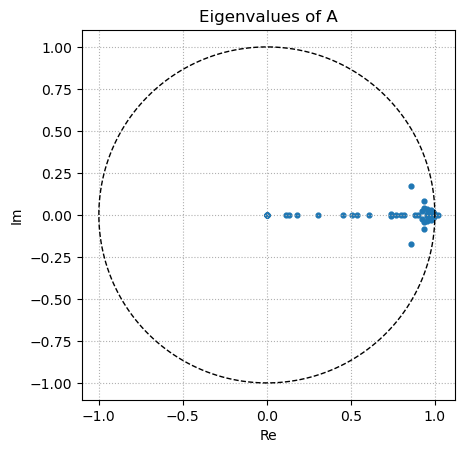

Controllability rank = 63 / 69  -> NOT full


In [5]:
# --- eigs & spectral radius ---
eigA = np.linalg.eigvals(A)
rhoA = np.max(np.abs(eigA))
print(f"Spectral radius ρ(A) = {rhoA:.6f}")
print(f"Max |eig|: {np.abs(eigA).max():.6f}  (stable if < 1 for discrete-time)")

# --- plot eigenvalues with unit circle ---
theta = np.linspace(0, 2*np.pi, 400)
plt.figure()
plt.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=1)  # unit circle
plt.scatter(eigA.real, eigA.imag, s=12)
plt.gca().set_aspect('equal', 'box')
plt.grid(True, linestyle=':')
plt.title("Eigenvalues of A")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()

# --- controllability of (A,B) in lifted space ---
n = A.shape[0]
nu = B.shape[1]
blocks = []
AB = B.copy()
for i in range(n):
    blocks.append(AB)
    AB = A @ AB
Ctrb = np.hstack(blocks)  # (n, n*nu)

rank = np.linalg.matrix_rank(Ctrb)
print(f"Controllability rank = {rank} / {n}  -> {'FULL' if rank == n else 'NOT full'}")

## 4) Check predictions
Pick a contiguous chunk from validation and compare rollouts.

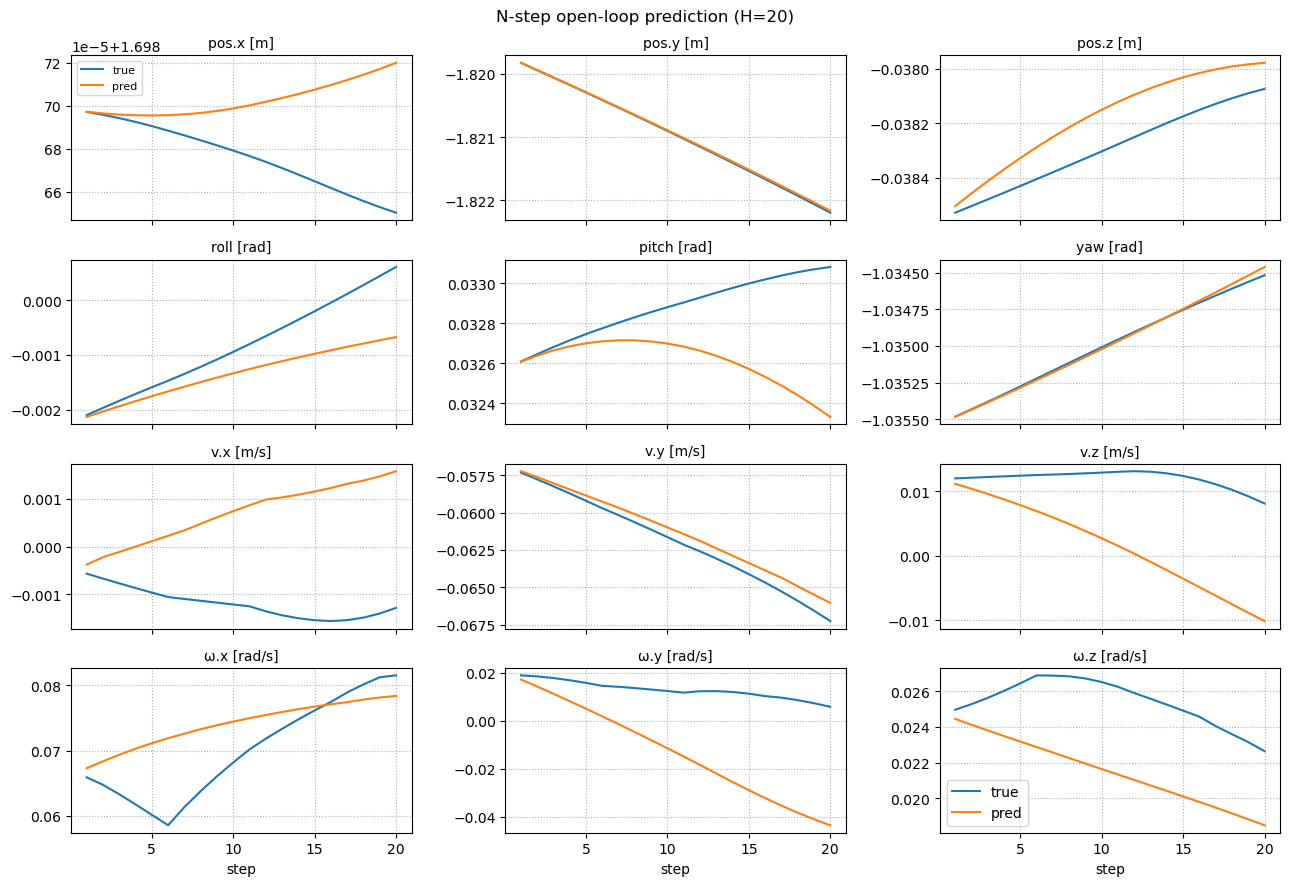

In [6]:
from eval_nstep import eval_nstep_window

H = 20  # horizon
res = eval_nstep_window(A, B, lift_fn, ds, splits, X0, X1, U0, p_max, H)

t = res["t"]
X_true_plot = res["X_true_plot"]
X_pred_plot = res["X_pred_plot"]
labels = res["labels"]

fig, axes = plt.subplots(4, 3, figsize=(13, 9), sharex=True)
axes = axes.ravel()
for i in range(12):
    ax = axes[i]
    ax.plot(t, X_true_plot[:, i], label="true")
    ax.plot(t, X_pred_plot[:, i], label="pred")
    ax.set_title(labels[i], fontsize=10)
    ax.grid(True, linestyle=':')
axes[-3].set_xlabel("step");  axes[-2].set_xlabel("step"); axes[-1].set_xlabel("step")
axes[0].legend(fontsize=8)
fig.suptitle(f"N-step open-loop prediction (H={len(t)})", y=0.98)
plt.tight_layout()
plt.legend()
plt.show()

In [7]:
# Use the raw (non-plot) arrays for metrics to avoid unwrap artifacts
X_true = res["X_true"]   # (H,12)
X_pred = res["X_pred"]   # (H,12)
labels = res["labels"]

def wrap_to_pi(a):
    return (a + np.pi) % (2*np.pi) - np.pi

# per-sample errors
err = np.zeros_like(X_true)
err[:, 0:3]  = X_pred[:, 0:3]  - X_true[:, 0:3]            # pos [m]
err[:, 3:6]  = wrap_to_pi(X_pred[:, 3:6] - X_true[:, 3:6])  # eul [rad]
err[:, 6:9]  = X_pred[:, 6:9]  - X_true[:, 6:9]            # v [m/s]
err[:, 9:12] = X_pred[:, 9:12] - X_true[:, 9:12]           # ω [rad/s]

# RMSE per state (12,)
rmse_per_state = np.sqrt(np.mean(err**2, axis=0))

print("Per-state RMSEs:")
for name, val in zip(labels, rmse_per_state):
    print(f"  {name:>12s}: {val:.4g}")

# Group-wise RMSE (combine xyz with RMS)
groups = [
    (slice(0,3),  "pos [m]"),
    (slice(3,6),  "eul [rad]"),
    (slice(6,9),  "lin vel [m/s]"),
    (slice(9,12), "ang vel [rad/s]"),
]
print("\nGroup-wise RMSEs:")
for sl, title in groups:
    grp = rmse_per_state[sl]
    print(f"  {title:>15s}: {np.sqrt(np.mean(grp**2)):.4g}")

# overall 12-state RMSE
overall_rmse = np.sqrt(np.mean(rmse_per_state**2))
print(f"\nOverall 12-state RMSE: {overall_rmse:.4g}")


Per-state RMSEs:
     pos.x [m]: 3.475e-05
     pos.y [m]: 1.59e-05
     pos.z [m]: 0.0001231
    roll [rad]: 0.0006415
   pitch [rad]: 0.0003592
     yaw [rad]: 1.987e-05
     v.x [m/s]: 0.002088
     v.y [m/s]: 0.0006839
     v.z [m/s]: 0.012
   ω.x [rad/s]: 0.006377
   ω.y [rad/s]: 0.03053
   ω.z [rad/s]: 0.004125

Group-wise RMSEs:
          pos [m]: 7.441e-05
        eul [rad]: 0.0004246
    lin vel [m/s]: 0.007045
  ang vel [rad/s]: 0.01817

Overall 12-state RMSE: 0.009745


In [8]:
from pathlib import Path
from edmd_runner import run_edmd_and_save

ROOT = Path("./../datasets/go1/flat_terrain/")
files = sorted(ROOT.glob("experiment*.h5"))

for fp in files:
    out = run_edmd_and_save(
        h5_path=fp,
        out_group="/eval",   # where we store X_true/X_pred for your ablation loader
        p_max=5,
        l2_reg=1e-6,
        val_frac=0.2,
        H=20,
        seed=42
    )
    print(fp.name, "overall_rmse:", out["overall_rmse"])
